In [9]:
# Import Library and code
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import pickle
from keras.models import Model, model_from_json

In [21]:
!nvidia-smi

Fri Apr  9 11:00:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import pandas as pd
data=pd.read_csv(r"/content/sample_data/final_dataset.csv")
#data['target'] = data['target'].map({0:0, 4:1})
data.dropna(axis=0,inplace=True)

In [23]:
def preprocess(tweet):
    tweet = re.sub('@[^\s]+','',str(tweet))
    tweet = re.sub(r'#', '', str(tweet))
    tweet= re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',str(tweet))    # Removing URLS
    tweet = re.sub('[^a-zA-Z]',' ',str(tweet))   #removing all punchuation and special character
    tweet = re.sub('[\s]+', ' ', str(tweet))  #removing extra white space
    tweet = re.sub('[\n]+', ' ', str(tweet))
    tweet = re.sub(r"[8:=;]['`\-]?p+", ' ', str(tweet))
    tweet = re.sub(r"[8:=;]['`\-]?[\/|l*]", ' ', str(tweet))
    tweet = re.sub(r"[8:=;]['`\-]?\(+", ' ', str(tweet))
    tweet = re.sub(r"[8:=;]['`\-]?[)d]+", ' ', str(tweet))
    tweet = re.sub("(.)\1\1+", ' ', str(tweet))
    tweet = re.sub("\1\1", ' ', str(tweet))
    tweet = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(tweet).lower())
    return tweet
data['tweet']= data['tweet'].apply(lambda x:preprocess(x))
data1=data

In [24]:
data1.head()

,Unnamed: 0,tweet,label
0,0,what amazing service apple won t even talk to ...,hate
1,1,ha not heavy machinery but it does what i need...,hate
2,2,contemplating giving in to the iphone bandwago...,hate
3,3,the battery is so painful i charge it overnig...,hate
4,4,the reason i don t have one iphone suck apple ...,hate


In [25]:
#Performing Text Normalization
nltk.download('punkt')
nltk.download('wordnet')
def token(tweet):
    tweet = word_tokenize(tweet)
    return tweet
data1['tweet']=data1['tweet'].apply(lambda x:token(x))

lem = WordNetLemmatizer()
def normalize(tweet):
    tweet = [lem.lemmatize(word) for word in tweet ]
    tweet = ' '.join(tweet)
    return tweet

data1['tweet']= data1['tweet'].apply(lambda x :normalize(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
x_tf=data1['tweet']
y_tf=data1['label']

In [27]:
x_tf.dropna(axis=0,inplace=True)
y_tf.dropna(axis=0,inplace=True)
#x_tf=x_tf.loc[0:177886]
y_tf=y_tf.map({"hate":1,"noHate":0})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_tf, y_tf,test_size = 0.35, random_state = 42,stratify=y_tf)

In [29]:
from gensim.models import Word2Vec
#from gensim.models.word2vec import Word2Vec
#from gensim.models import KeyedVectors
#word2vec_model = KeyedVectors.load_word2vec_format(r'D:\nlp\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
train_data = list(map(lambda x: x.split(), X_train))
word2vec_model = Word2Vec(train_data,size=100,workers=3,min_count=4)

In [30]:
input_length = 100 # Model Input Length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(x_tf)
vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

Tokenizer vocab length: 185296
X_train.shape: (284300, 100)
X_test.shape : (153086, 100)


In [31]:
embedding_matrix = np.zeros((vocab_length,100))
for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
embedding_matrix.shape

(185296, 100)

In [32]:
X_train

array([[    0,     0,     0, ...,    10,  7595,  1167],
       [    0,     0,     0, ..., 26768,   201,  9130],
       [  109,   810,    32, ..., 17400, 21523,   106],
       ...,
       [    0,     0,     0, ...,  6351,   653,  1320],
       [    0,     0,     0, ...,     7, 36538,   204],
       [    0,     0,     0, ...,   156, 11843,   413]], dtype=int32)

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def Model():
    layer = Embedding(input_dim = 185296,output_dim = 100,weights=[embedding_matrix],input_length=100,trainable=False)
    model = Sequential([layer, Bidirectional(LSTM(200, dropout=0.2, return_sequences=True)),
        Bidirectional(LSTM(150, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.1, return_sequences=True)),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

model_bilstm = Model()
model_bilstm.summary()
ec= EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=30, mode='min')
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_bilstm.fit(X_train, y_train,batch_size=512,epochs=30,validation_split=0.2,callbacks=[ec , mc],verbose=1)


Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          18529600  
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 100, 400)          481600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 100, 300)          661200    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 100, 200)          320800    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 64)            64064     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)            

In [46]:
from keras import models 
saved_model = models.load_model('best_model.h5')
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.765, Test: 0.755


In [ ]:
import matplotlib.pyplot as plt

acc_1,  val_acc_1  = history.history['accuracy'], history.history['val_accuracy']
loss_1, val_loss_1 = history.history['loss'], history.history['val_loss']
epochs = range(len(acc_1))
plt.plot(epochs, acc_1, 'c', label='Train_acc')
plt.plot(epochs, val_acc_1, 'b', label='Val_acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss_1, 'c', label='Train_loss')
plt.plot(epochs, val_loss_1, 'b', label='Val_loss')
plt.title('Loss')
plt.legend()

In [ ]:
score = model_bilstm.evaluate(X_test, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1094/1094 [==============================] - 30s 27ms/step - loss: 0.3705 - accuracy: 0.8379
ACCURACY: 0.8379428386688232
LOSS: 0.3704540431499481


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model_bilstm.predict(X_test)
y_pred


array([[0.8740851 ],
       [0.47815245],
       [0.00401276],
       ...,
       [0.99794036],
       [0.02634604],
       [0.05124794]], dtype=float32)

In [ ]:
for n, i in enumerate(y_pred):
  if i >= .5:
    y_pred[n] = 1
  else:
    y_pred[n] = 0  

In [ ]:
y_pred

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84    280000
           1       0.84      0.83      0.84    280000

    accuracy                           0.84    560000
   macro avg       0.84      0.84      0.84    560000
weighted avg       0.84      0.84      0.84    560000



Text(0.5, 1.0, 'Confusion Matrix')

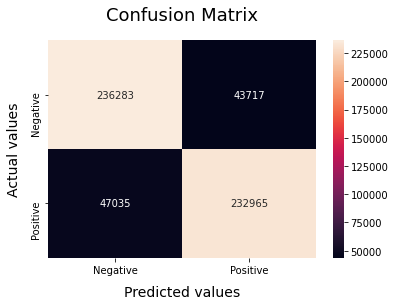

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
categories  = ['Negative','Positive']
matrix=confusion_matrix(y_test.values, y_pred)
sns.heatmap(matrix,annot = matrix,fmt = '', xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
